# Duke HAR Data Model 1: Artificial Neural Network

INPUT: **rolled_data.csv**

This notebook label encodes Subject_ID and Activity (our y variable). It then one-hot encodes Subject_ID to be used as a feature in our model. The validation method used for the model is Leave One Group Out (LOGO) validation. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import keras
from keras import models
from keras import layers
import numpy as np
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
random.seed(321)

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
tf.__version__

'2.2.0'

### Load Data

In [4]:
df  = pd.read_csv('rolled_data.csv')

In [5]:
df = df.reindex(columns = ['ACC1', 'ACC2', 'ACC3', 'TEMP', 'EDA', 'BVP', 'HR', 'Magnitude', 'Subject_ID', 'Round', 'Activity'])

In [6]:
df.head(3)

,ACC1,ACC2,ACC3,TEMP,EDA,BVP,HR,Magnitude,Subject_ID,Round,Activity
0,40.22500,28.29750,39.225000,32.35600,0.265940,-0.21875,76.10525,62.913102,19-001,1,Baseline
1,40.17500,28.34250,39.175000,32.35475,0.265556,-1.07075,75.96875,62.870169,19-001,1,Baseline
2,40.12663,28.38337,39.125543,32.35350,0.265140,-0.75950,75.83375,62.826763,19-001,1,Baseline


### Label Encode Activity and Subject_ID

We encode the y variable as we need to one-hot encode this y variable for the model. The label each class is associated with is printed below.

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])

activity_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(activity_name_mapping)

{'Activity': 0, 'Baseline': 1, 'DB': 2, 'Type': 3}


In [8]:
le1 = LabelEncoder()
df['Subject_ID'] = le1.fit_transform(df['Subject_ID'])

### Split into test and train sets (by Subject ID)

In [9]:
ID_list = list(df['Subject_ID'].unique())
random.shuffle(ID_list)
train = pd.DataFrame()
test = pd.DataFrame()

The size of the test train split can be changed by changing the index below. For our purposes, n = 45 for train and n = 10 for test.

In [10]:
train = df[df['Subject_ID'].isin(ID_list[:45])]
test = df[df['Subject_ID'].isin(ID_list[45:])]
print(train.shape, test.shape)

(216108, 11) (47196, 11)


### Choose features to be used in model

Pick one of the three following code cells to choose what features are used in the model. Do not run them all. To uncomment or comment multiple selected lines, press control + /. 

##### All Features

In [31]:
X_train = train.iloc[:,0:9]
X_test = test.iloc[:,0:9]

y_train = train.iloc[:,-1].values
y_test = test.iloc[:,-1].values

print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape)

(216108, 9) (216108,) (47196, 9) (47196,)


##### Mechanical Features Only

In [14]:
# X_train = train.iloc[['ACC1', 'ACC2', 'ACC3', 'Magnitude', 'Subject_ID']]
# X_test = test.iloc[['ACC1', 'ACC2', 'ACC3', 'Magnitude', 'Subject_ID']]

# y_train = train.iloc[:,-1].values
# y_test = test.iloc[:,-1].values

# print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape)

##### Physiological Features Only

In [15]:
# X_train = train.iloc[['TEMP', 'EDA', 'HR', 'BVP', 'Subject_ID']]
# X_test = test.iloc[['TEMP', 'EDA', 'HR', 'BVP', 'Subject_ID']]

# y_train = train.iloc[:,-1].values
# y_test = test.iloc[:,-1].values

# print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape)

We create X_train_df below so that we are able to use the Subject_ID column later on, to iterate through our leave one group out validation. 

In [32]:
X_train_df = X_train

### Apply one-hot encoding to Subject ID

One hot encoding is applied so subject_ID, so that it may be used as a variable in our model. This allows the model to understand that testing data contains new subjects that are not present in the training data. 

In [33]:
X_train['train'] =1
X_test['train'] = 0

combined = pd.concat([X_train, X_test])
combined = pd.concat([combined, pd.get_dummies(combined['Subject_ID'])], axis =1)

In [34]:
X_train = combined[combined['train'] == 1]
X_test = combined[combined['train'] == 0]

X_train.drop(["train", "Subject_ID"], axis = 1, inplace = True)
X_test.drop(["train", "Subject_ID"], axis = 1, inplace = True)
print(X_train.shape, X_test.shape, X_train.shape[0] + X_test.shape[0])

(216108, 63) (47196, 63) 263304


We encode the y variable as we need to one-hot encode this y variable for the model. Tensorflow requires one-hot encoding for more than two classes in the target class.

In [35]:
y_train_dummy = np_utils.to_categorical(y_train)
y_test_dummy = np_utils.to_categorical(y_test)

### Scale/normalize features

Scaling is used to change values without distorting differences in the range of values for each sensor. We do this because different sensor values are not in similar ranges of each other and if we did not scale the data, gradients may oscillate back and forth and take a long time before finding the local minimum. It may not be necessary for this data, but to be sure, we normalized the features.

The standard score of a sample x is calculated as:

$$z = \frac{x-u}{s}$$

Where u is the mean of the data, and s is the standard deviation of the data of a single sample. The scaling is fit on the training set and applied to both the training and test set.

In [36]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train.iloc[:,:8] = ss.fit_transform(X_train.iloc[:,:8])
X_test.iloc[:,:8] = ss.transform(X_test.iloc[:,:8])

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [38]:
X_train = X_train.values

### Neural Network

- 2 hidden **fully connected** layers with 32 nodes

- The **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

- **Softmax** acitvation function - Used to generate probabilities for each class as an output in the final fully connected layer of the model

We decided to use ADAM as our optimizer as it is computationally efficient and updates the learning rate on a per-parameter basis, based on a moving estimate per-parameter gradient, and the per-parameter squared gradient. 

### LOOCV

__Leave One Out CV:__
Each observation is considered as a validation set and the rest n-1 observations are a training set. Fit the model and predict using 1 observation validation set. Repeat this for n times for each observation as a validation set.
Test-error rate is average of all n errors.

__Advantages:__ takes care of both drawbacks of validation-set method
1. No randomness of using some observations for training vs. validation set like in validation-set method as each observation is considered for both training a›nd validation. So overall less variability than Validation-set method due to no randomness no matter how many times you run it.
2. Less bias than validation-set method as training-set is of n-1 size. Because of this reduced bias, reduced over-estimation of test-error, not as much compared to validation-set method.

__Disadvantages:__
1. Even though each iterations test-error is un-biased, it has a high variability as only one-observation validation-set was used for prediction.
2. Computationally expensive (time and power) especially if dataset is big with large n as it requires fitting the model n times. Also some statistical models have computationally intensive fitting so with large dataset and these models LOOCV might not be a good choice.

In [40]:
from sklearn.model_selection import LeaveOneGroupOut

# Lists to store metrics
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# Define the K-fold Cross Validator
groups = X_train_df['Subject_ID'].values 
inputs = X_train
targets = y_train_dummy
logo = LeaveOneGroupOut()

logo.get_n_splits(inputs, targets, groups)

cv = logo.split(inputs, targets, groups)

# LOGO
fold_no = 1
for train, test in cv:
    #Define the model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax')) #4 outputs are possible 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=32,
              epochs=10,
              verbose=1)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    y_pred = np.argmax(model.predict(inputs[test]), axis=-1)
    f1 = (f1_score(np.argmax(targets[test], axis=1), (y_pred), average = 'weighted'))
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%, F1 of {f1}')
    f1_per_fold.append(f1)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1
    

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1:{f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')                     
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
6599/6599 [==============================] - 7s 1ms/step - loss: 0.4871 - accuracy: 0.8106
Epoch 2/10
6599/6599 [==============================] - 8s 1ms/step - loss: 0.3375 - accuracy: 0.8690
Epoch 3/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.3129 - accuracy: 0.8773
Epoch 4/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.2968 - accuracy: 0.8826 0s - loss: 0.2972 - accura
Epoch 5/10
6599/6599 [==============================] - 12s 2ms/step - loss: 0.2867 - accuracy: 0.8868
Epoch 6/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.2800 - accuracy: 0.8895
Epoch 7/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.2742 - accuracy: 0.8920
Epoch 8/10
6599/6599 [==============================] - 11s 2

6599/6599 [==============================] - 12s 2ms/step - loss: 0.2840 - accuracy: 0.8902
Epoch 6/10
6599/6599 [==============================] - 14s 2ms/step - loss: 0.2775 - accuracy: 0.8934 1s - loss: 0.2779 - accuracy: 0.89 - ETA: 1s - loss: 0.2779 - accuracy:  - ETA: 
Epoch 7/10
6599/6599 [==============================] - 14s 2ms/step - loss: 0.2703 - accuracy: 0.8954
Epoch 8/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.2679 - accuracy: 0.8961
Epoch 9/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.2628 - accuracy: 0.8983- ETA: 2s - loss: 0.2628  - ETA: 0s -
Epoch 10/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.2621 - accuracy: 0.8982
Score for fold 12: loss of 1.7746444513716138; accuracy of 49.73832528180354%, F1 of 0.41135910677684656
------------------------------------------------------------------------
Training for fold 13 ...
-----------------------------------------------------------------------

6599/6599 [==============================] - 10s 1ms/step - loss: 0.2659 - accuracy: 0.8957
Score for fold 23: loss of 1.2432553950738194; accuracy of 59.44041867954911%, F1 of 0.5532798843104608
------------------------------------------------------------------------
Training for fold 24 ...
------------------------------------------------------------------------
Training for fold 24 ...
Epoch 1/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.5034 - accuracy: 0.8034 2s - loss: 0.5359 - accura - ETA: 0s -
Epoch 2/10
6599/6599 [==============================] - 12s 2ms/step - loss: 0.3472 - accuracy: 0.8680
Epoch 3/10
6599/6599 [==============================] - 13s 2ms/step - loss: 0.3147 - accuracy: 0.8797
Epoch 4/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.3000 - accuracy: 0.8846
Epoch 5/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.2904 - accuracy: 0.8878 4s - loss: 0.2912 - ac - ETA: 0s - loss: 0.2904 - accu

6599/6599 [==============================] - 9s 1ms/step - loss: 0.4853 - accuracy: 0.8126
Epoch 2/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.3358 - accuracy: 0.8715
Epoch 3/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.3074 - accuracy: 0.8818 1s - loss: 0.3
Epoch 4/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.2964 - accuracy: 0.8851
Epoch 5/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.2885 - accuracy: 0.8870: 0s - loss: 0.2887 - accuracy: 
Epoch 6/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.2836 - accuracy: 0.8892
Epoch 7/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.2789 - accuracy: 0.8903
Epoch 8/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.2735 - accuracy: 0.8925
Epoch 9/10
6599/6599 [==============================] - 15s 2ms/step - loss: 0.2709 - accuracy: 0.8927
Epoch 10/10
6599/6599 [=================

Epoch 1/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.5015 - accuracy: 0.8044
Epoch 2/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.3387 - accuracy: 0.8707 0s - loss: 0.340
Epoch 3/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.3070 - accuracy: 0.8804
Epoch 4/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.2915 - accuracy: 0.8872
Epoch 5/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.2808 - accuracy: 0.8908 0s - los
Epoch 6/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.2755 - accuracy: 0.8926
Epoch 7/10
6599/6599 [==============================] - 9s 1ms/step - loss: 0.2679 - accuracy: 0.8952: 0s -
Epoch 8/10
6599/6599 [==============================] - 10s 2ms/step - loss: 0.2672 - accuracy: 0.8954 0s - loss: 0.2674 
Epoch 9/10
6599/6599 [==============================] - 11s 2ms/step - loss: 0.2604 - accuracy: 0.8992 0s - los
Epoch 10/10
6599

Please edit the name of the model below. This will be used to save the model and figures associated with the model.

In [ ]:
model_name = '10_TF_ANN'

In [49]:
!mkdir -p saved_model
model.save(f'saved_model/{model_name}') 

INFO:tensorflow:Assets written to: saved_model/10_TF_ANN/assets


# Prediction

We obtain the predicted class for each test set sample by using the argmax function on the predicted probabilities that are output from our model. Argmax returns the class with the highest probability.

In [50]:
model = tf.keras.models.load_model(f'saved_model/{model_name}')

In [51]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [52]:
results = model.evaluate(X_test, y_test_dummy, batch_size=128)
print("Test loss, Test acc:", results)

369/369 [==============================] - 0s 825us/step - loss: 1.4306 - accuracy: 0.6684
Test loss, Test acc: [1.430555538317202, 0.6684252902788372]


A **confusion matrix** is generated to observe where the model is classifying well and to see classes which the model is not classifying well.

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [54]:
cm = confusion_matrix(y_pred, y_test)
cm

array([[18825,  2402,   187,    52],
       [ 1588,  8786,   753,  2264],
       [  931,  3749,  2714,   281],
       [  715,  2562,   165,  1222]])

We normalize the confusion matrix to better understand the proportions of classes classified correctly and incorrectly for this model. 

In [55]:
cm= cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
cm

array([[0.87696823, 0.11189789, 0.00871145, 0.00242244],
       [0.11858711, 0.65611231, 0.0562318 , 0.16906878],
       [0.12130293, 0.48846906, 0.35361564, 0.03661238],
       [0.15330189, 0.54931389, 0.03537736, 0.26200686]])

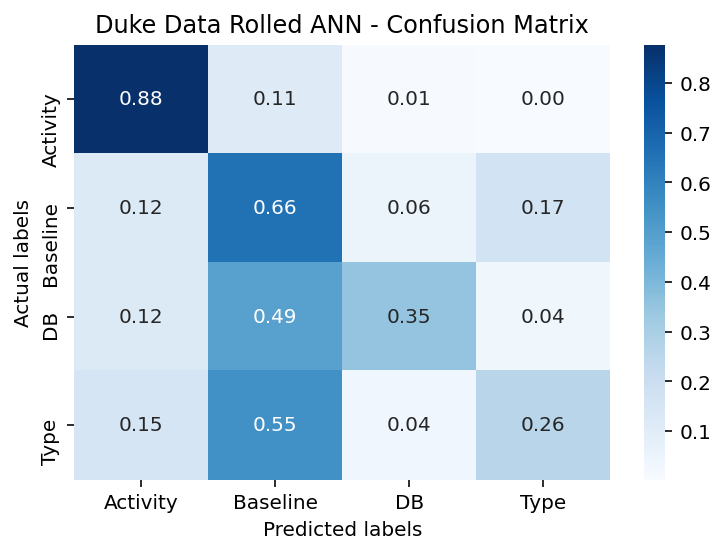

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Duke Data Rolled ANN - Confusion Matrix')
plt.savefig(f'10_figures/{model_name}_CF.png')

The **accuracy** score represents the proportion of correct classifications over all classifications.

The **F1 score** is a composite metric of two other metrics:

Specificity: proportion of correct 'positive predictions' over all 'positive' predictions.

Sensitivity: number of correct 'negative' predictions over all 'negative' predictions.

The F1 score gives insight as to whether all classes are predicted correctly at the same rate. A low F1 score and high accuracy can indicate that only a majority class is predicted.

In [58]:
a_s = accuracy_score(y_test, y_pred)
f1_s = f1_score(y_test, y_pred, average = 'weighted')

print(f'Accuracy Score: {a_s:.3f} \nF1 Score: {f1_s:.3f}')

Accuracy Score: 0.668 
F1 Score: 0.677
